### Table des matières
* [Partie1: Jeux de  données](#p1)
  * [1.Les librairies](#lib)
  * [2.Dataset initial](#di)
  * [3.Idée d'application](#app)
       
      
* [Parti2:Nettoyage des données](#p2)
  * [1.Vérifications des valeurs des ingrédients](#col)
  * [2.Les outliers](#ou)
  * [3.Imputation](#imp)
  * [4.Sauvegarde des données dans un fichier csv](#cs)
  

# Partie1: Jeux  de données <a class="anchor" id="p1"></a>
## 1.Les librairies<a class="anchor" id="lib"></a>


In [1]:
import pandas as pd #(Vaex – Faster Pandas Alternate in Python)
import numpy as np
from hurry.filesize import size
import missingno as msno
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('seaborn')
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
import warnings
warnings.filterwarnings('ignore')


## 2.Dataset initial<a class="anchor" id="di"></a>

In [3]:
df=pd.read_csv("data.csv",sep='\t',on_bad_lines='skip',low_memory=False)

In [46]:
df.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [4]:
def print_shape(dataframe):
    print('Number of rows:', dataframe.shape[0],'\n')
    print('Number of columns:', dataframe.shape[1])

In [12]:
#shape
print('Initial dataset \n')
print_shape(df)

Initial dataset 

Number of rows: 320772 

Number of columns: 162


In [9]:
def print_memory(dataframe):
    #Memory consumption
    df_memory = dataframe.memory_usage().sum()
    # Let's print out the memory consumption
    print('Total Current memory is-', df_memory,'Bytes.','===>',size(df_memory))


In [14]:
print_memory(df)


Total Current memory is- 415720640 Bytes. ===> 396M


In [12]:
#columns
cols= df.columns.tolist()
print('Columns list:\n',cols)

Columns list:
 ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'p

In [5]:
def print_nb_duplicated_rows(dataframe,cols):
    #duplicated rows
    dataframe=dataframe[cols]
    bool_series = dataframe.duplicated()
    print('Number of duplicated rows:',(bool_series).sum())


In [14]:
print_nb_duplicated_rows(df,cols)

Number of duplicated rows: 0


In [5]:
def print_missing_val(dataframe,how):
    if how=='graph':
        #plot % of missing
        msno.bar(dataframe)
    elif how=='values':
        #print % of missing
        dataframe.isnull().mean()

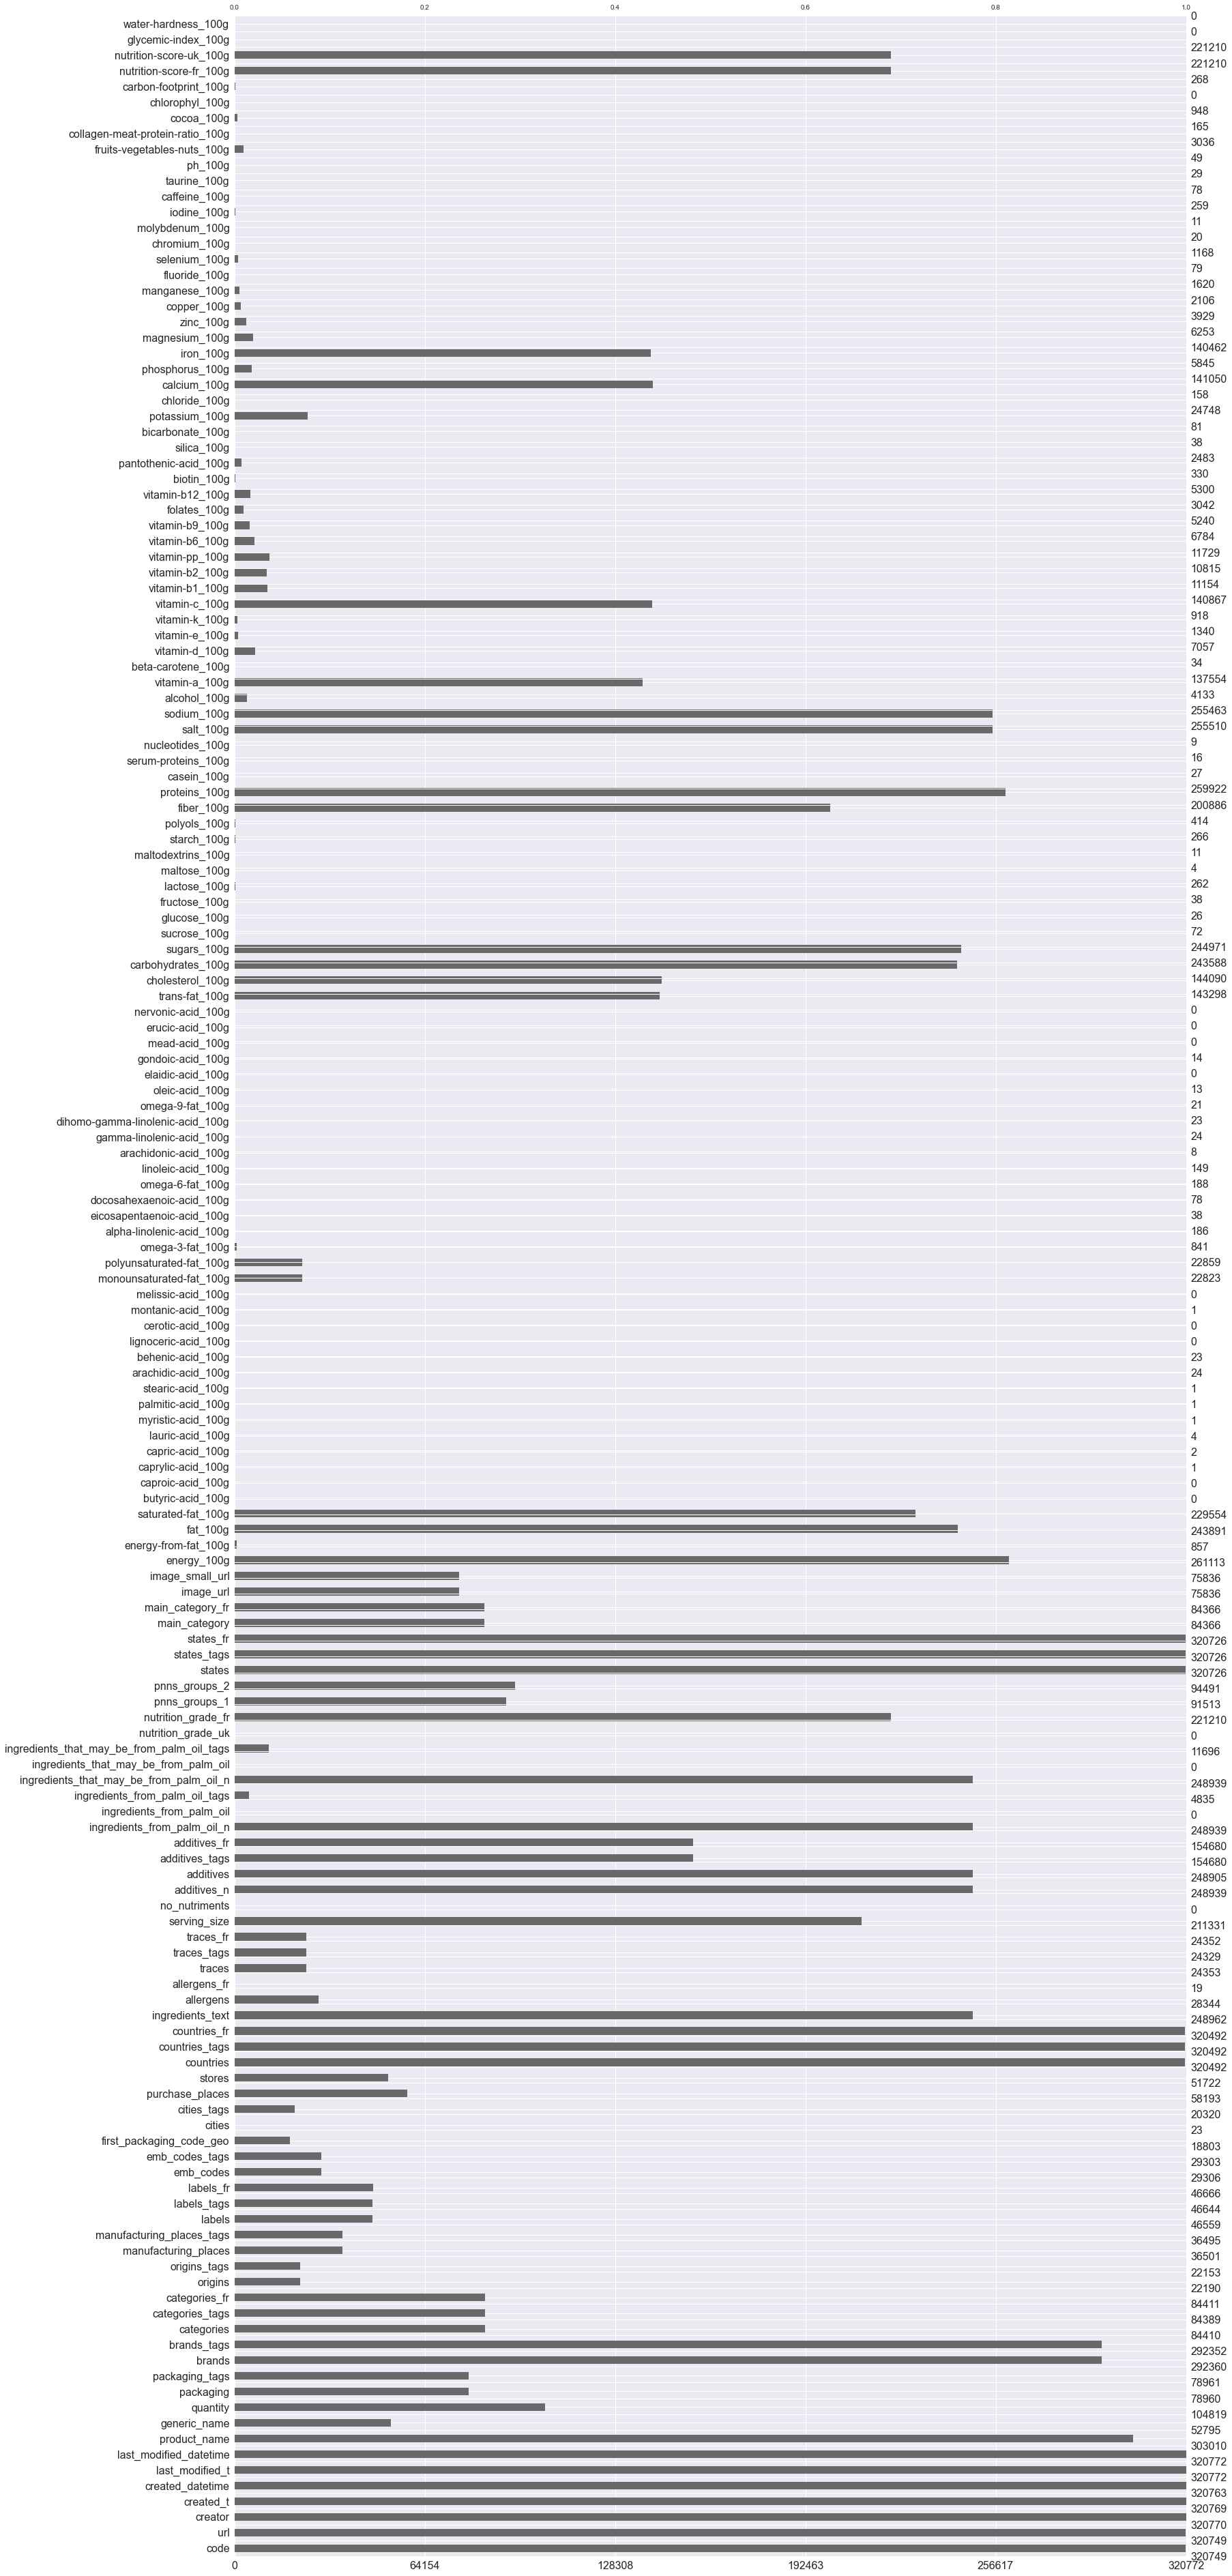

In [19]:
print_missing_val(df,'graph')

## 3.Idée d'application<a class="anchor" id="app"></a>
<p> L'idée est pour un produit scanné via son code à barre, l'application permet d'afficher si le produit est excellent, bon ou mauvais en fonction d'un score calculé.
 <br>
Lorsque son impact est jugé négatif , elle permet de recommander des produits.
 <br>
Le score est un pourcentage:
 <br>
- excellent: 75<=score<=100
 <br>
- bon: 50<=score<=74
 <br>
- médiocre: 25<=score<=49
 <br>
- mauvais: score<=25
 
 Le score est  calculé en fonction de la qualité nutritionnelle,la teneur de fruits , légumes et noix et la présence d'additifs.
<br>
    <b> score=60%*qualité nutritionnelle+20%*teneurfruits-leg_noix+20%presence additifs</b>
<br>
 Les variables à utiliser:'code','pnns_groups_1', 'pnns_groups_2','energy_100g','fat_100g', 'saturated-fat_100g','sugars_100g','fiber_100g', 'proteins_100g','sodium_100g','fruits-vegetables-nuts_100g','additives_n'
  
   </p>                 

# Partie2: Nettoyage des données <a class="anchor" id="p2"></a>
## 1.Vérifications des valeurs des ingrédients<a class="anchor" id="col"></a>

In [6]:
#vs=['code','pnns_groups_1', 'pnns_groups_2','energy_100g','fat_100g', 'saturated-fat_100g','sugars_100g','fiber_100g', 'proteins_100g','sodium_100g','fruits-vegetables-nuts_100g','additives_n']
df_app=df[['code','pnns_groups_1', 'pnns_groups_2','energy_100g','fat_100g', 'saturated-fat_100g','sugars_100g','fiber_100g', 'proteins_100g','sodium_100g','fruits-vegetables-nuts_100g','additives_n']
]

In [21]:
print_memory(df_app)

Total Current memory is- 30794240 Bytes. ===> 29M


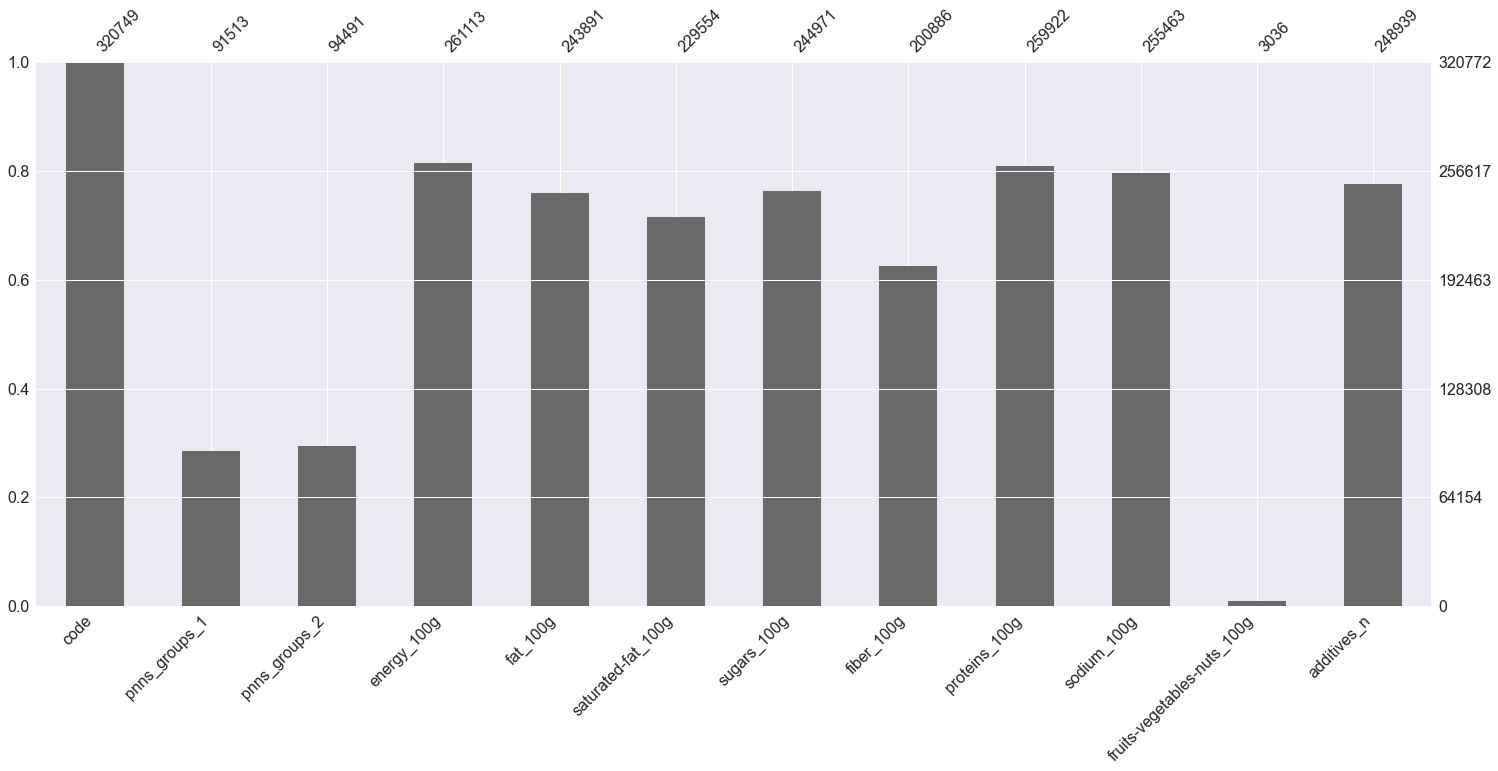

In [22]:
print_missing_val(df_app,'graph')

In [9]:
#check values 
#min max of each ingredient column in the datframe
def minMax_ingredients(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])


In [7]:
ingredients_g=['fat_100g', 'saturated-fat_100g','sugars_100g','fiber_100g', 'proteins_100g','sodium_100g']

In [10]:
ingredients=ingredients_g+['energy_100g']
df_app[ingredients].apply(minMax_ingredients)

,fat_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,energy_100g
min,0.00,0.0,-17.86,-6.7,-800.0,0.0,0.0
max,714.29,550.0,3520.00,5380.0,430.0,25320.0,3251373.0


In [11]:
 #keep only rows with ingr1 values  between 0 and 100

#'fruits-vegetables-nuts_100g'==> is a %
#'additives_n'==> is a number of food additives
seuil_low_100=100
seuil_up_100=0
for ing in ingredients_g:
    df_app.drop(df_app[(df_app[ing] < seuil_up_100) | (df_app[ing] > seuil_low_100)].index,inplace=True)

In [13]:
#keep only rows with 'fat_100g'>='saturated-fat_100g'
df_app.drop(df_app[df_app['saturated-fat_100g']>df_app['fat_100g']].index,inplace=True)

In [15]:
#check energy values 1g(glucid)==>4kcal, 1g(protein)==>4kcal, 1g(lipid)==>9kcal,if a product of 100g contains onlylipid, so it has 900kcal like energy
#replace outliers with 900*4,186(1 kcal = 4,1868 kJ) because energy_100g is on kJ
seuil_energy=900*4.186
df_app[df_app['energy_100g']>seuil_energy].shape    
df_app['energy_100g'].mask(df_app['energy_100g'] >seuil_energy, seuil_energy, inplace=True)




In [14]:
print_nb_duplicated_rows(df_app,'code')
#delete duplicated product
df_app = df_app.drop_duplicates('code', keep='first')


Number of duplicated rows: 22


## 2.Les outliers<a class="anchor" id="ou"></a>

In [16]:
list_pnns1=df_app['pnns_groups_1'].unique().tolist()
print(list_pnns1)

[nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks', 'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs', 'Beverages', 'Fat and sauces', 'fruits-and-vegetables', 'Milk and dairy products', 'Salty snacks', 'sugary-snacks', 'cereals-and-potatoes', 'salty-snacks']


**Remarques concernant les valeurs de pnns_groups_1**
<br>
  - 'Sugary snacks':'sugary-snacks'
<br>
  - 'Salty snacks' : 'salty-snacks'
<br>
  - 'Fruits and vegetables' : 'fruits-and-vegetables'
<br>
  - 'Cereals and potatoes' : 'cereals-and-potatoes'
 <br>
  - 'unknown'  :It is possible to change this value by the most frequent name of group <br>
  
**Despite the similarity between the name of groups,values are different**

In [17]:
list_pnns2=df_app['pnns_groups_2'].unique().tolist()
print(list_pnns2)

[nan, 'unknown', 'Vegetables', 'Biscuits and cakes', 'Bread', 'Legumes', 'Pizza pies and quiche', 'Meat', 'Sweets', 'Non-sugared beverages', 'Sweetened beverages', 'Dressings and sauces', 'One-dish meals', 'vegetables', 'Soups', 'Chocolate products', 'Alcoholic beverages', 'Fruits', 'Sandwich', 'Cereals', 'Milk and yogurt', 'Fats', 'Cheese', 'Appetizers', 'Nuts', 'Breakfast cereals', 'Artificially sweetened beverages', 'Fruit juices', 'Eggs', 'Fish and seafood', 'Dried fruits', 'Ice cream', 'Processed meat', 'Potatoes', 'Dairy desserts', 'Fruit nectars', 'pastries', 'Tripe dishes', 'fruits', 'Salty and fatty products', 'cereals', 'legumes', 'nuts']


**Remarques concernant les valeurs de pnns_groups_2**
<br>
  - 'Legumes':'legumes'======>boxplot shows that are 2 different pnss_groups
<br>
  - 'Vegetables' : 'vegetables'======>boxplot shows that are 2 different pnss_groups
<br>
  - 'Fruits ' : 'fruits'======>boxplot shows that are 2 different pnss_groups
<br>
  - 'Nuts' : 'nuts'======>datset contains one ligne with pnns_groups_2 is egal to nuts.It will be deleted so its  correspondant 'pnns_groups_1'='salty-snacks'
<br>
  - 'unknown' : It is possible to change this value by the most frequent name of group <br>
  
**Despite the similarity between the name of groups,values are different**

In [18]:
df[df['pnns_groups_2']=='nuts'].shape #its  correspondant 'pnns_groups_2'='salty-snacks'

(1, 162)

In [19]:
df_app.drop(df_app[df_app['pnns_groups_2']=='nuts'].index,inplace=True)#this c

In [20]:
def plot_box_ingredients_pnss_group(pn,group,data,ingr,nb,path):  
    """
    gives the boxplot of the specified ingr of the data data given a pn 
    
    This function plots the boxplot of the specified ingredients of the datframe data given a specific pnss_group .

    Parameters
    ----------
    pn : string
        a value of the specific pnss_group group.
    group : string
        Specific pnss_group.
    data : Dataframe
        Dataframe containing pn and ingr.
    ingr : list
        list of the ingredients.
    nb  : int
        Number to format the figure name 
    path: string
          path to save the figure of plotbox
    Returns
    -------
    int
        The plotbox figure of the distribution of data[ingr] for a specific pn.

  

    Examples
    --------
    >>> plot_box_ingredients_pnss_group('legumes',df,['fat_100g','energy_100g'],1,'Boxplots/)
  
    """
    if pd.isna(pn)==False:
        myFig=plt.figure(figsize=(10,4))
        data_pnns=data[data[group]==pn]
        data=data_pnns[ingr]
        ax=data.boxplot(column=ingr,figsize=(15,5))
        ax.set_title(pn)
        figname=path+'boxplot'+str(nb)+pn+'.png'
        myFig.savefig(figname, format="png")



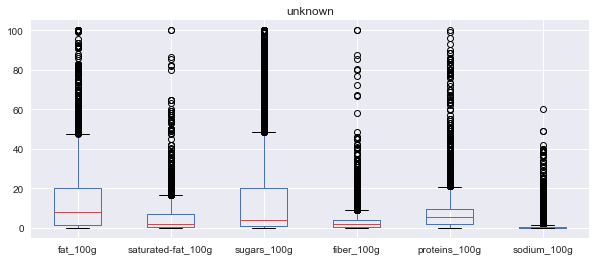

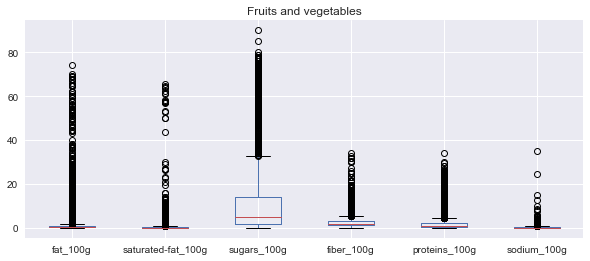

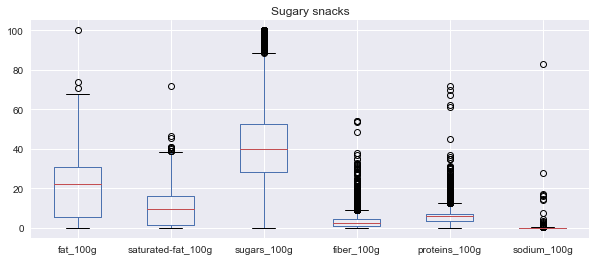

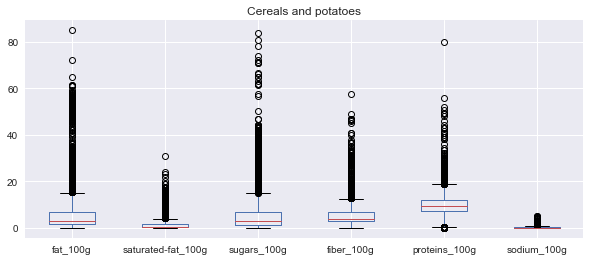

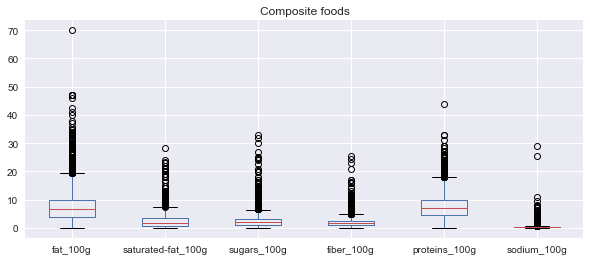

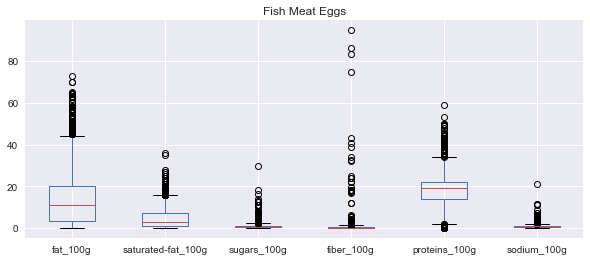

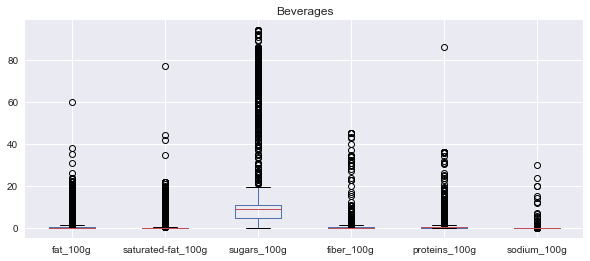

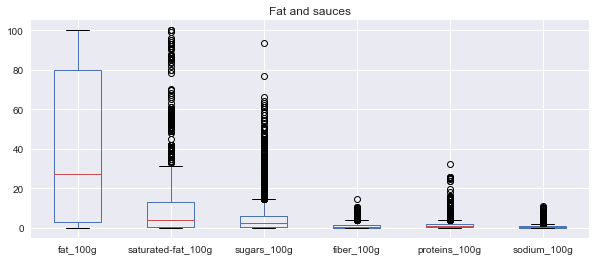

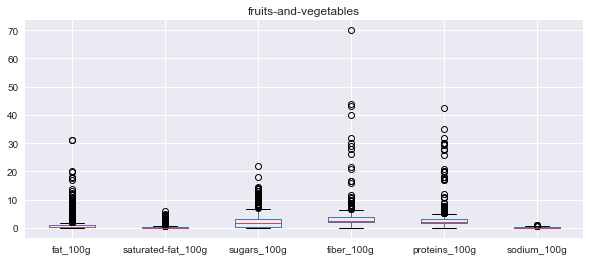

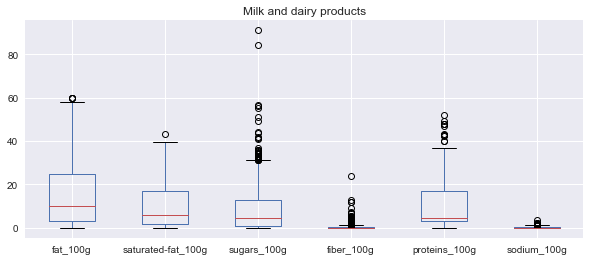

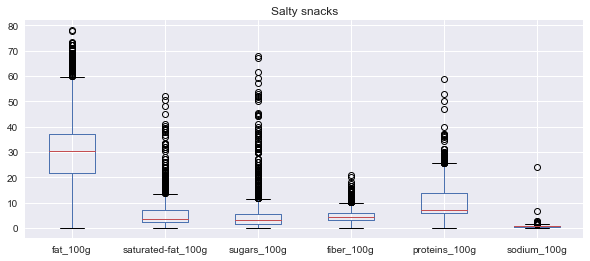

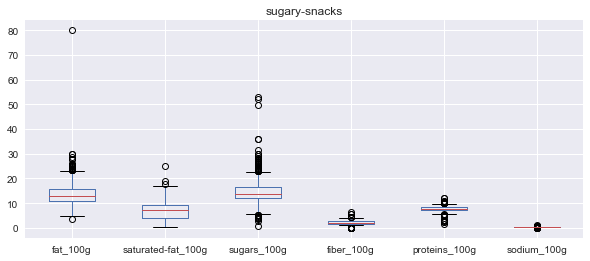

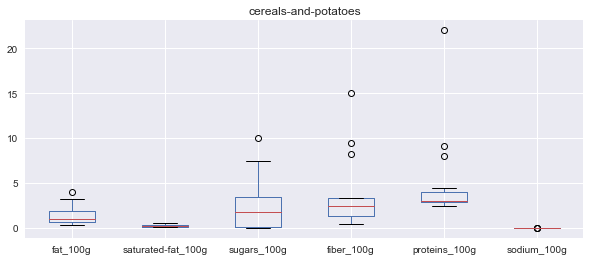

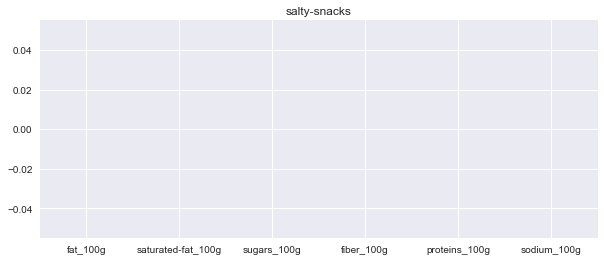

In [21]:
i=0
group='pnns_groups_1'
list_pnns=list_pnns1
path='Boxplots1_with_outliers/'
for pn in list_pnns:
    i+=1
    plot_box_ingredients_pnss_group(pn,group,df_app,ingredients_g,i,path)

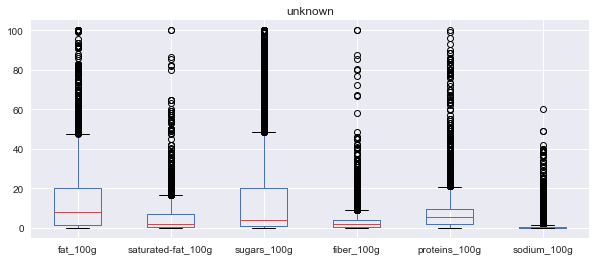

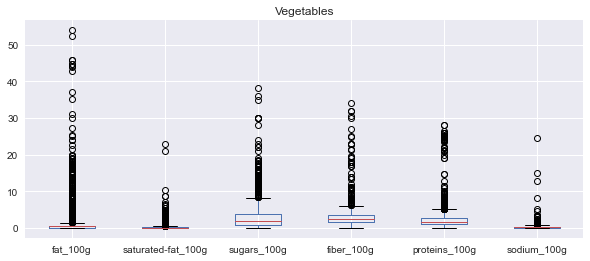

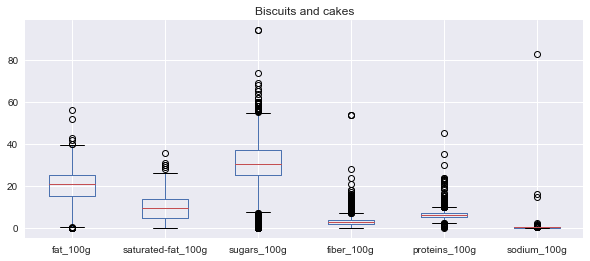

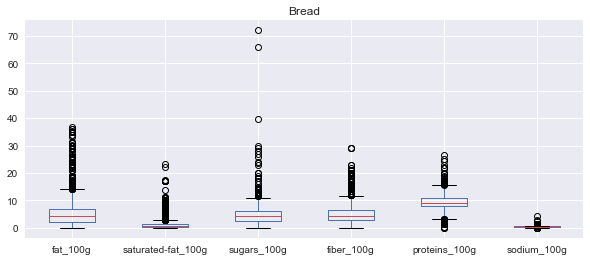

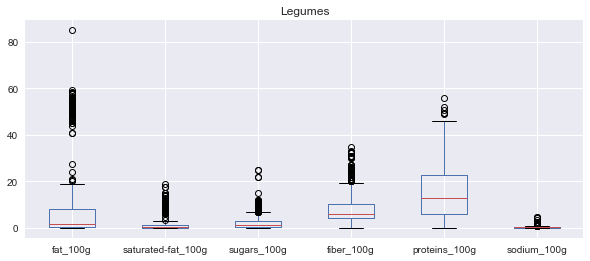

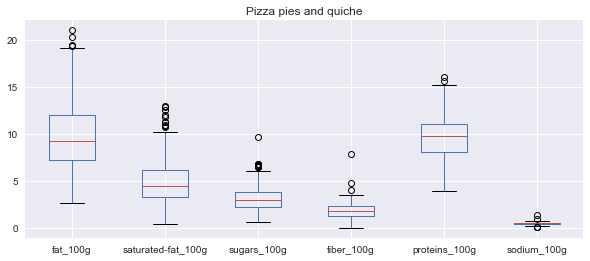

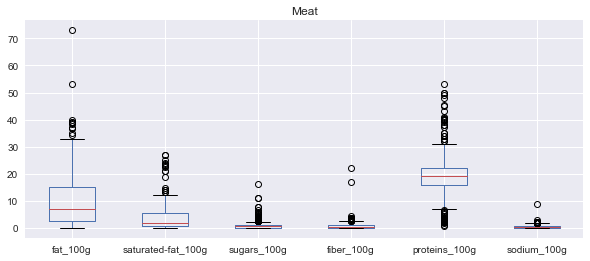

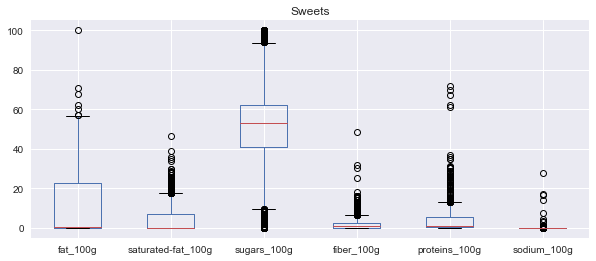

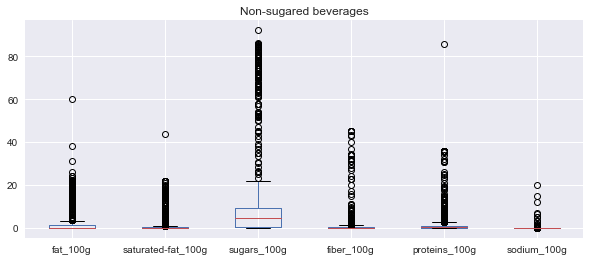

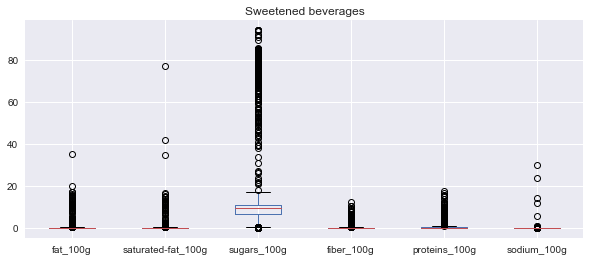

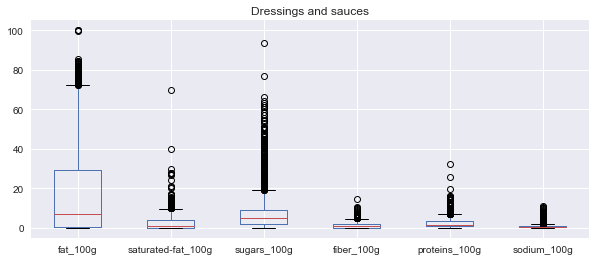

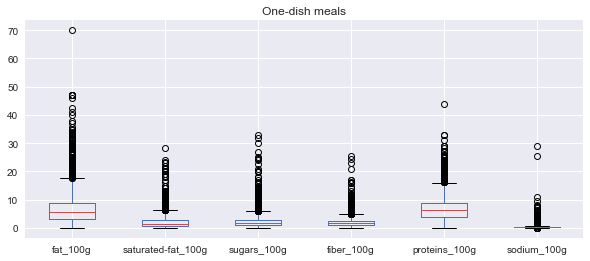

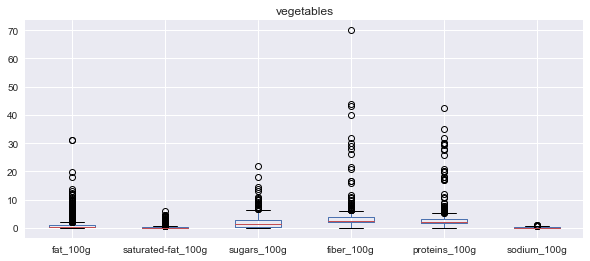

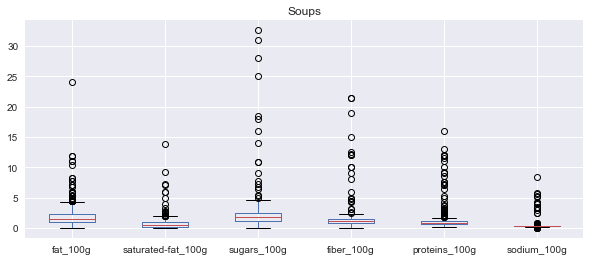

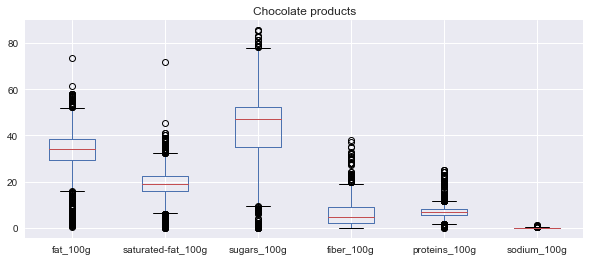

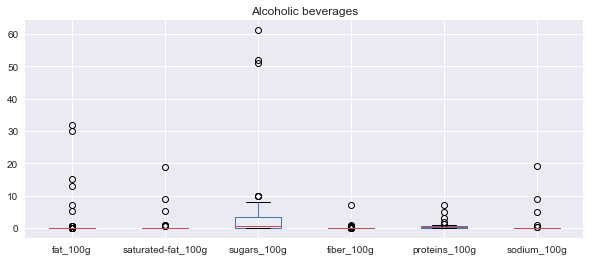

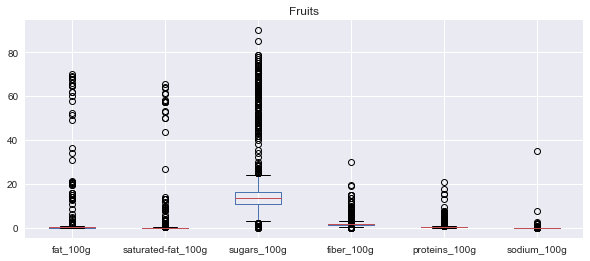

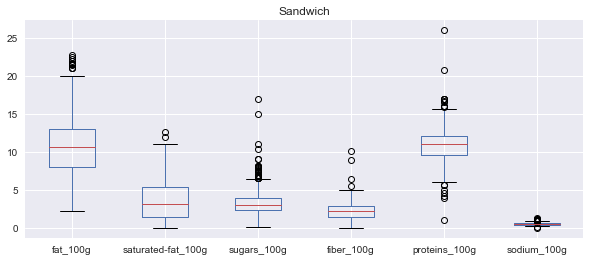

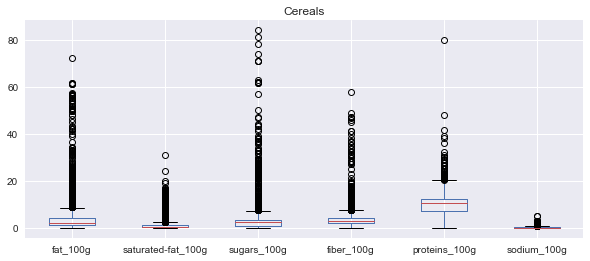

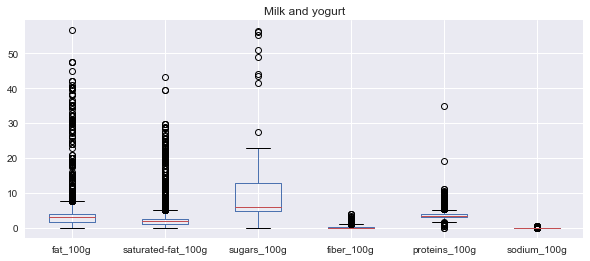

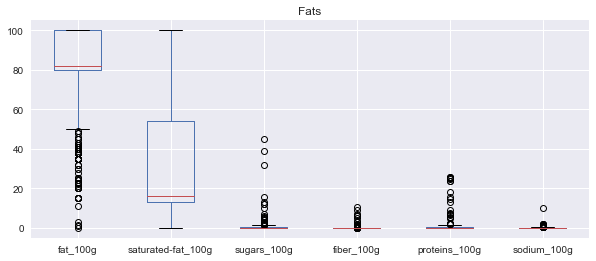

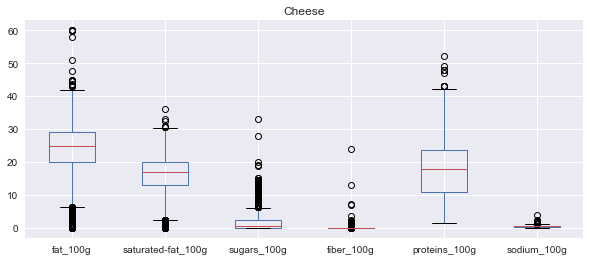

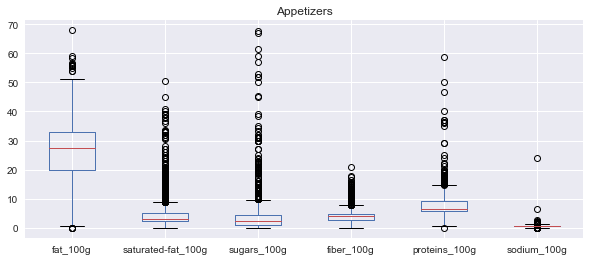

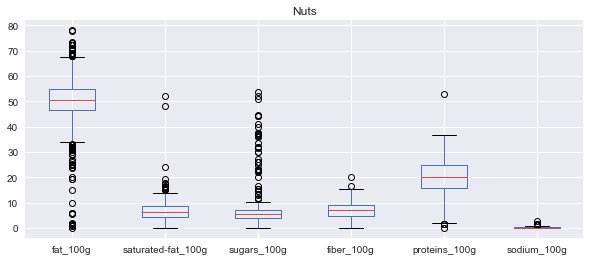

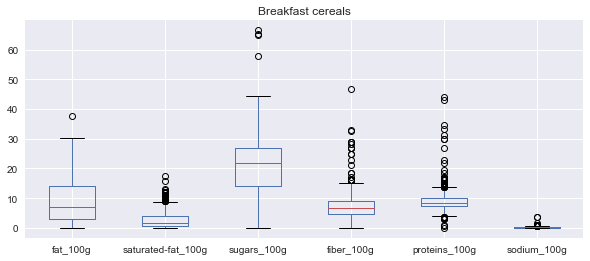

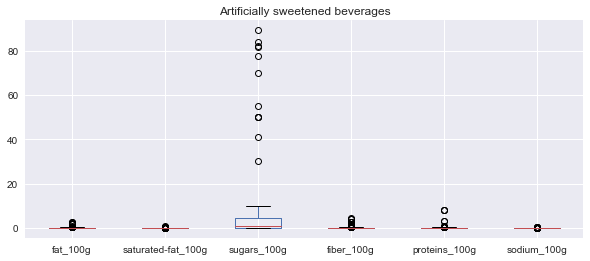

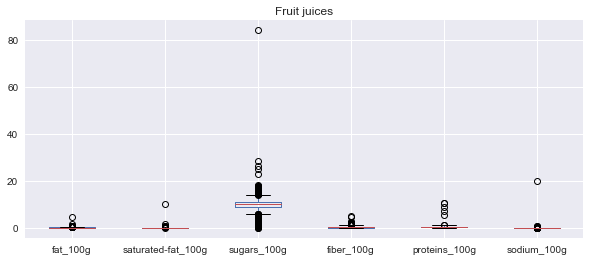

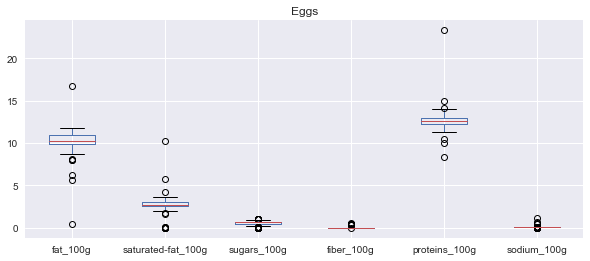

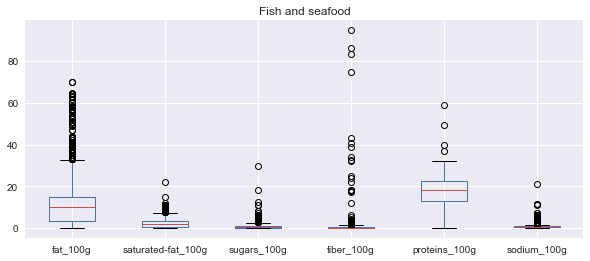

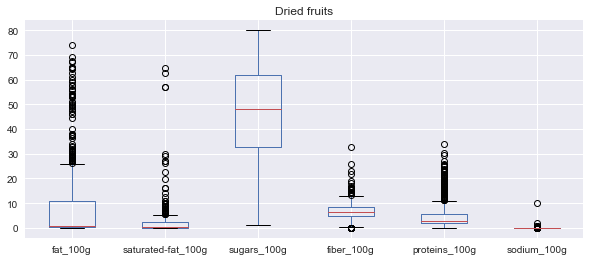

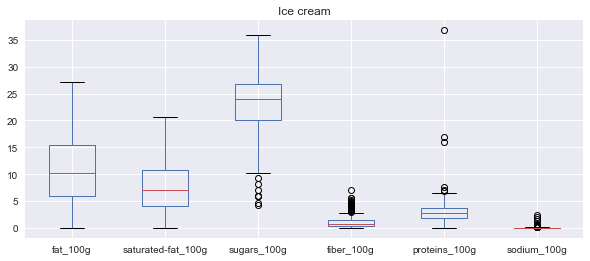

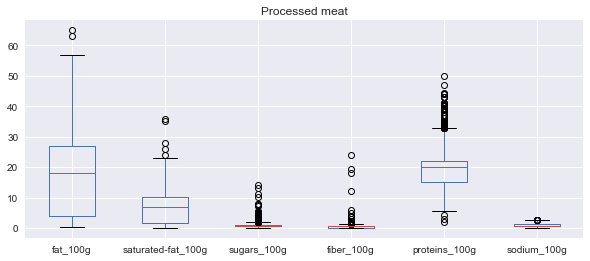

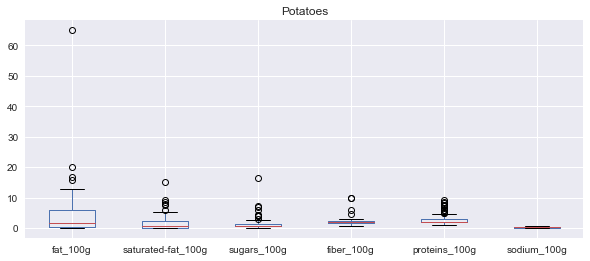

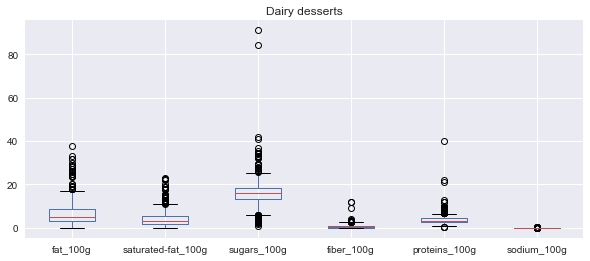

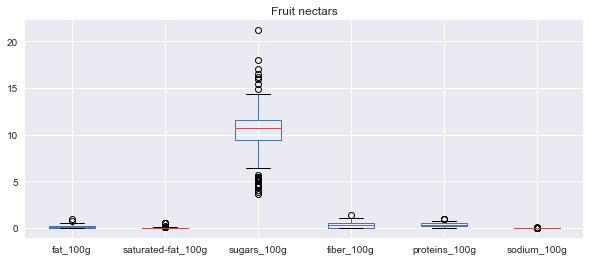

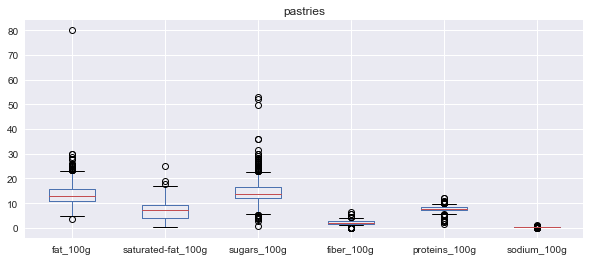

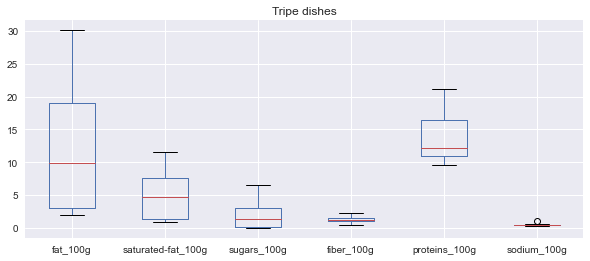

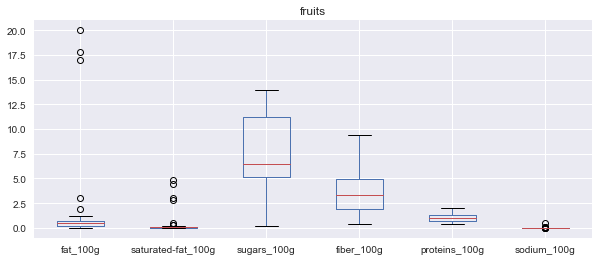

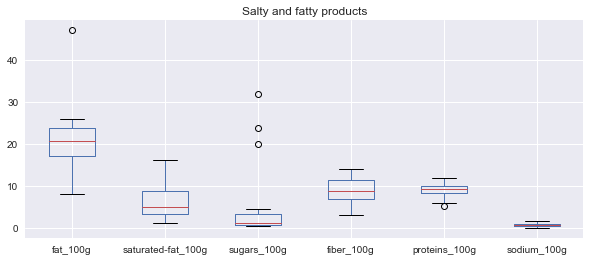

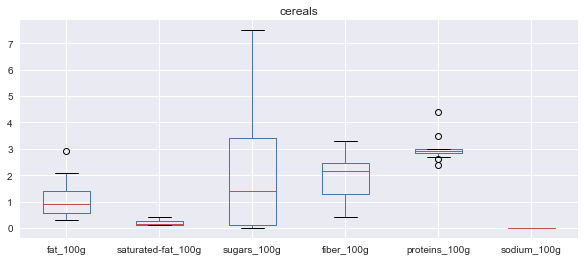

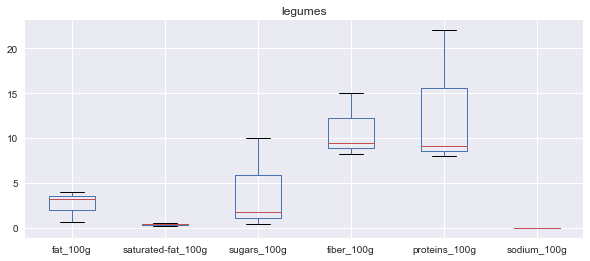

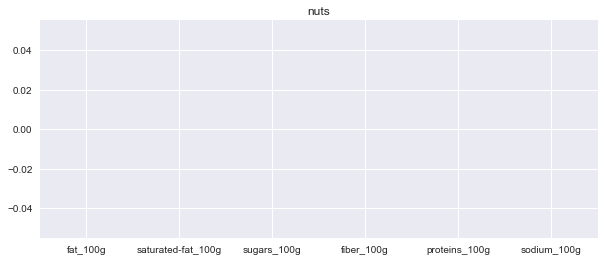

In [21]:
i=0
group='pnns_groups_2'
list_pnns=list_pnns2
path='Boxplots2_with_outliers/'
for pn in list_pnns:
    i+=1
    plot_box_ingredients_pnss_group(pn,group,df_app,ingredients_g,i,path)

In [29]:
def detect_outlier(dataframe,column):
    if pd.isna(column)==False:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        if pd.isna(lower_limit):
            print('lower limit of ',column,' is nan')
        if pd.isna(upper_limit):
            print('upper_limit of ',column,' is nan')
    #here are the outliers
    dataframe[(dataframe[column]<lower_limit)|(dataframe[column]>upper_limit)]
    return lower_limit,upper_limit

In [30]:
def remove_outlier(dataframe,column,lower_limit,upper_limit):
    #df_no_outlier = dataframe[(dataframe[column]>lower_limit)&(dataframe[column]<upper_limit)]
    dataframe.drop(dataframe[(dataframe[column]<lower_limit)|(dataframe[column]>upper_limit)].index,inplace=True)
    #return df_no_outlier

In [31]:
df_app_pnss=df_app.copy()

In [32]:
ings=['energy_100g', 'fat_100g','saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g','sodium_100g']

In [37]:

print('before deleting outliers:\n')
df_no_outlier=df_app.copy()
df_no_outliers=pd.DataFrame()
print_shape(df_no_outlier)
for pn in list_pnns2:    
    if (pd.isna(pn)==False): #& (pn!='unknown'):
        
        df_app_pnss=df_app[df_app['pnns_groups_2']==pn]       
        
        for ing in ings:
            
            lower_limit,upper_limit=detect_outlier(df_app_pnss,ing)    
            remove_outlier(df_app_pnss,ing,lower_limit,upper_limit)

        df_no_outliers=df_no_outliers.append(df_app_pnss)
    
        
print('after deleting outliers:\n')
print_shape(df_no_outliers)       
#print_missing_val(df_no_outliers,'graph') 

before deleting outliers:

Number of rows: 320354 

Number of columns: 12
lower limit of  energy_100g  is nan
upper_limit of  energy_100g  is nan
lower limit of  fat_100g  is nan
upper_limit of  fat_100g  is nan
lower limit of  saturated-fat_100g  is nan
upper_limit of  saturated-fat_100g  is nan
lower limit of  sugars_100g  is nan
upper_limit of  sugars_100g  is nan
lower limit of  fiber_100g  is nan
upper_limit of  fiber_100g  is nan
lower limit of  proteins_100g  is nan
upper_limit of  proteins_100g  is nan
lower limit of  sodium_100g  is nan
upper_limit of  sodium_100g  is nan
after deleting outliers:

Number of rows: 72793 

Number of columns: 12


In [38]:
df_no_outlier_pnss_g2=df_no_outliers.copy()
df_no_outliers=pd.DataFrame()
print('before deleting outliers:\n')
print_shape(df_no_outlier_pnss_g2)
for pn in list_pnns1:
    
    if (pd.isna(pn)==False): #& (pn!='unknown'):
        
        df_app_pnss=df_no_outlier_pnss_g2[df_no_outlier_pnss_g2['pnns_groups_1']==pn]
       
        
        for ing in ings:
            
            lower_limit,upper_limit=detect_outlier(df_app_pnss,ing)    
            remove_outlier(df_app_pnss,ing,lower_limit,upper_limit)

        df_no_outliers=df_no_outliers.append(df_app_pnss)
    
        
print('after deleting outliers:\n')
print_shape(df_no_outliers) 

before deleting outliers:

Number of rows: 72793 

Number of columns: 12
lower limit of  energy_100g  is nan
upper_limit of  energy_100g  is nan
lower limit of  fat_100g  is nan
upper_limit of  fat_100g  is nan
lower limit of  saturated-fat_100g  is nan
upper_limit of  saturated-fat_100g  is nan
lower limit of  sugars_100g  is nan
upper_limit of  sugars_100g  is nan
lower limit of  fiber_100g  is nan
upper_limit of  fiber_100g  is nan
lower limit of  proteins_100g  is nan
upper_limit of  proteins_100g  is nan
lower limit of  sodium_100g  is nan
upper_limit of  sodium_100g  is nan
after deleting outliers:

Number of rows: 61342 

Number of columns: 12


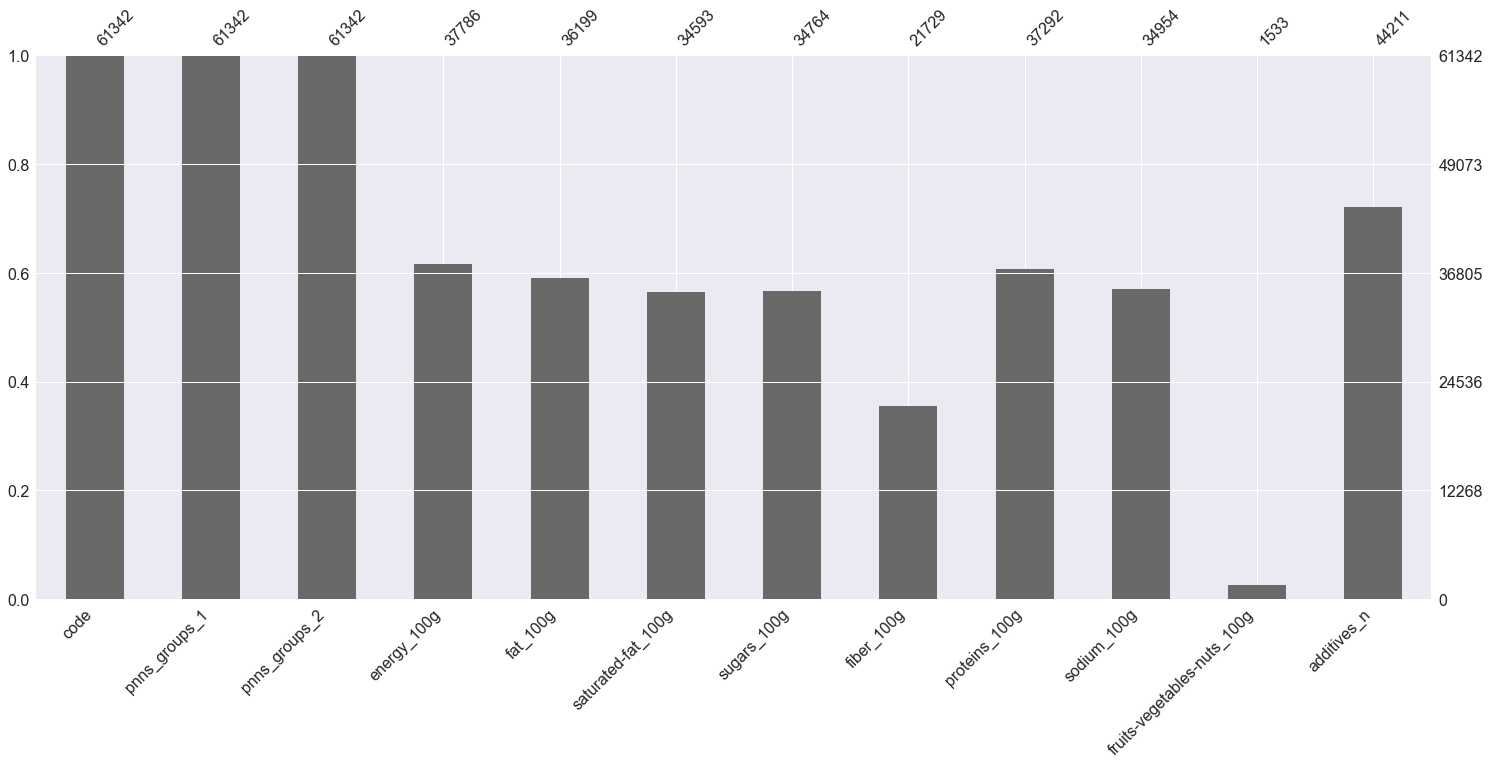

In [39]:
print_missing_val(df_no_outliers,'graph')

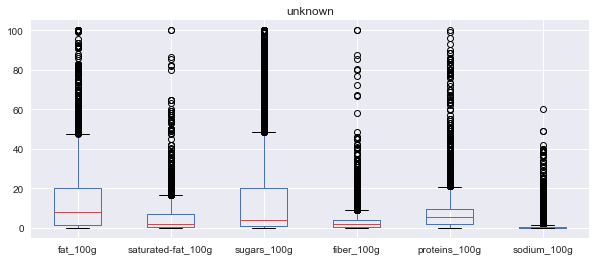

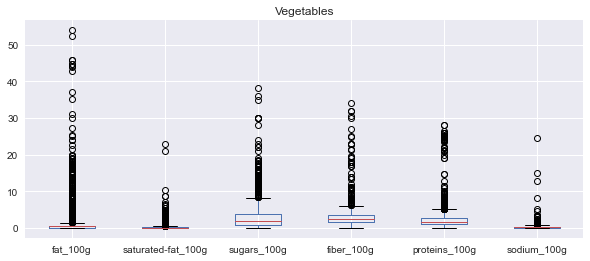

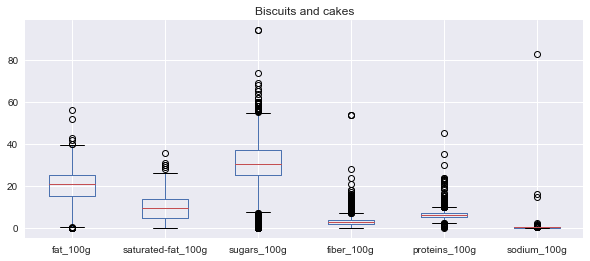

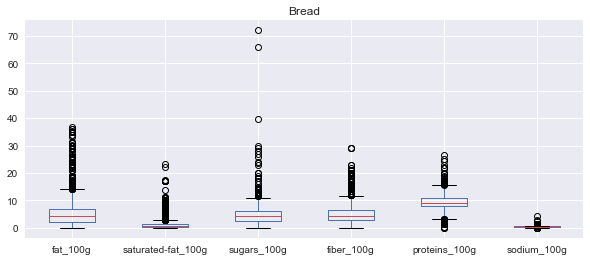

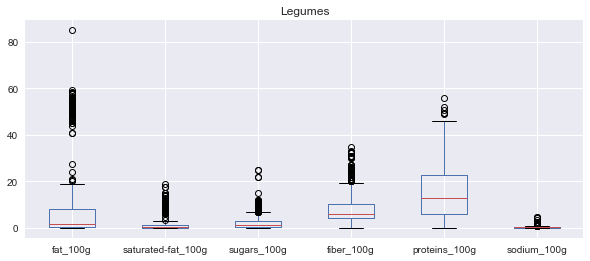

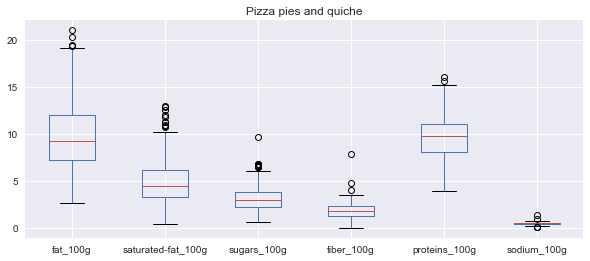

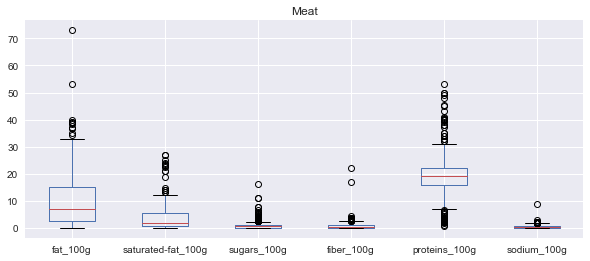

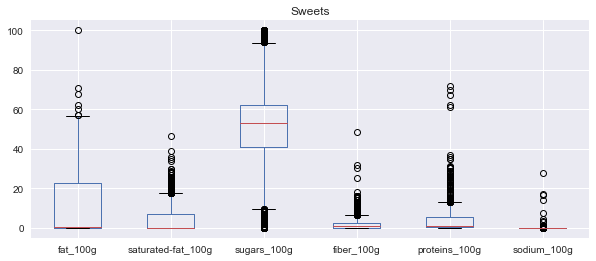

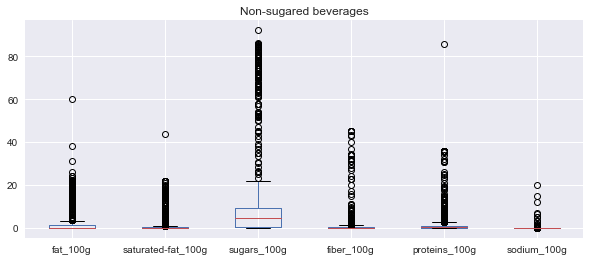

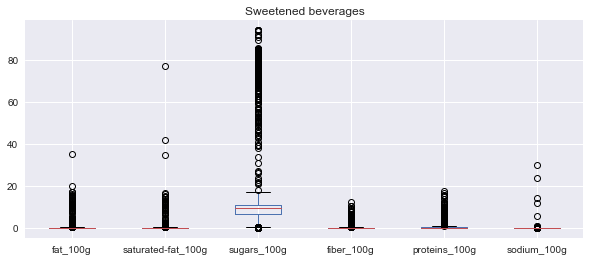

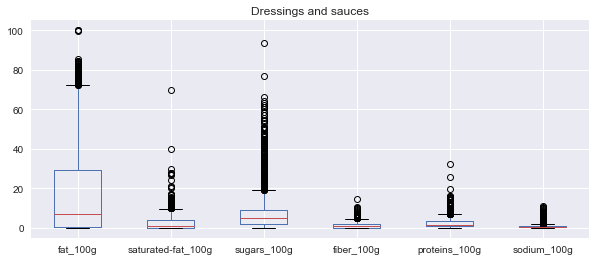

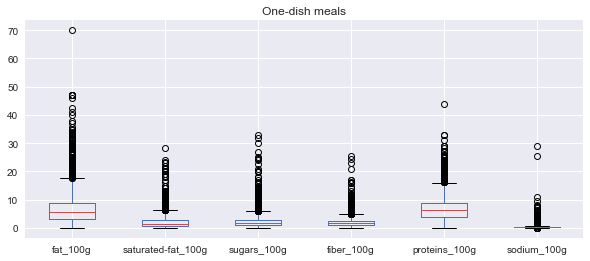

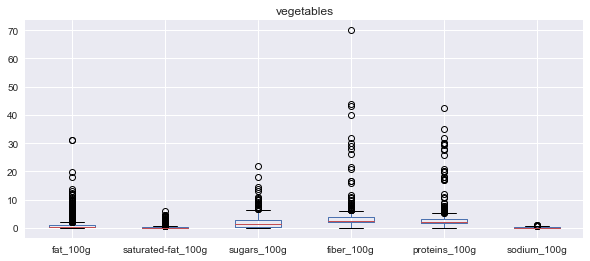

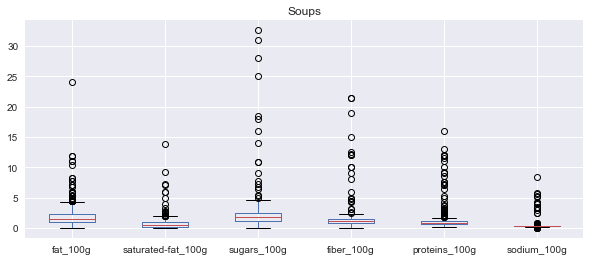

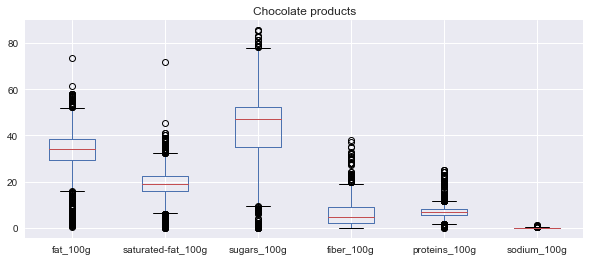

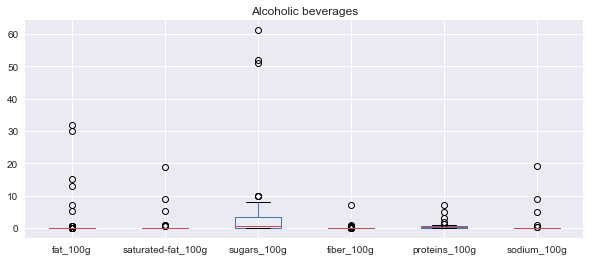

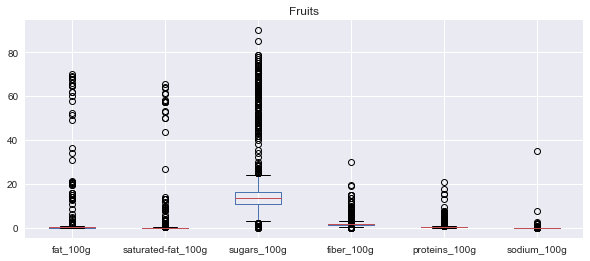

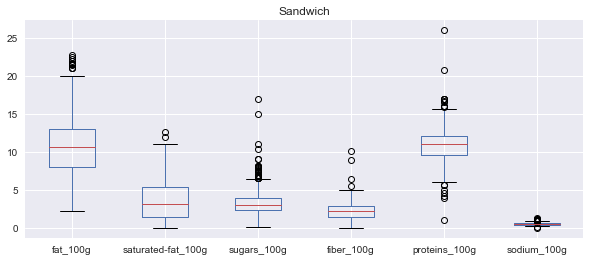

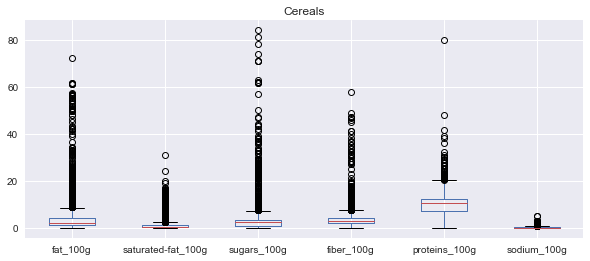

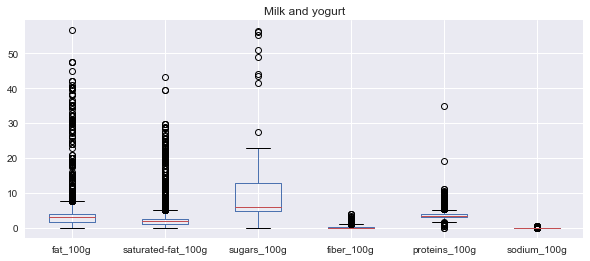

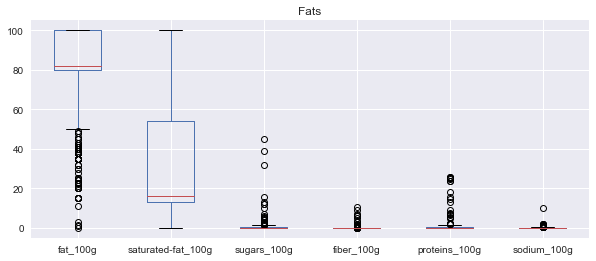

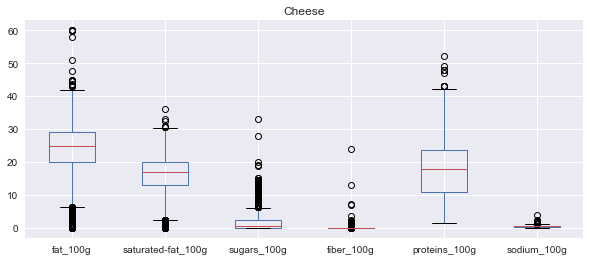

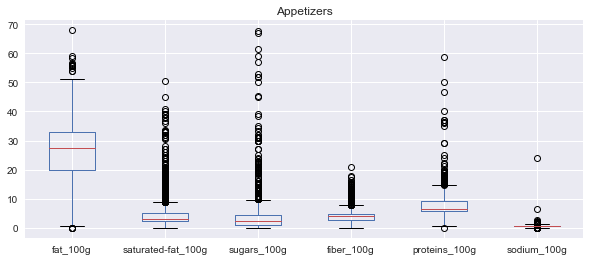

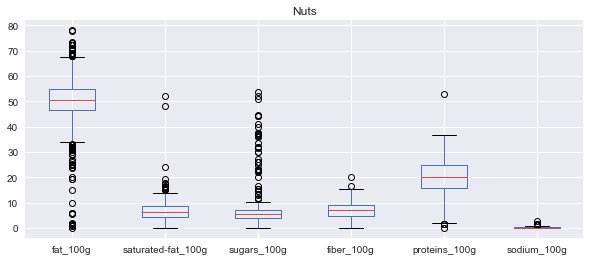

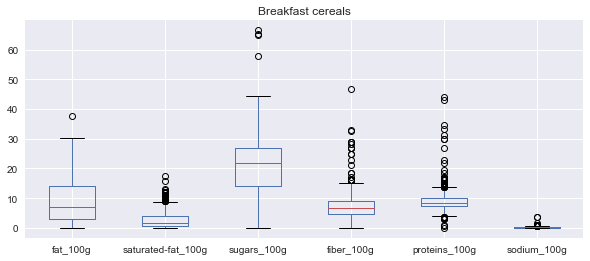

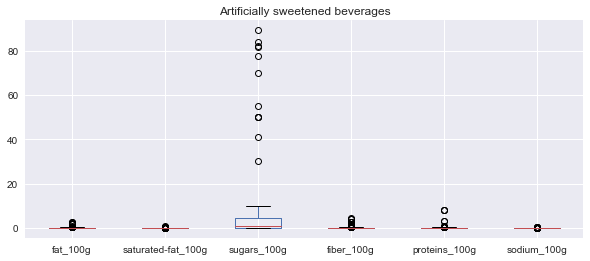

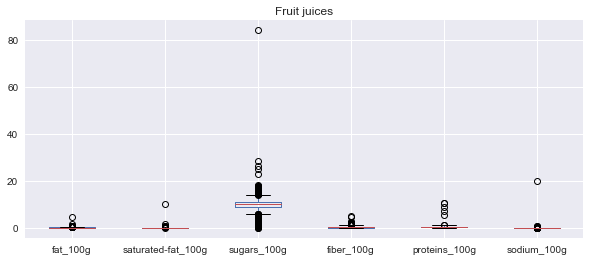

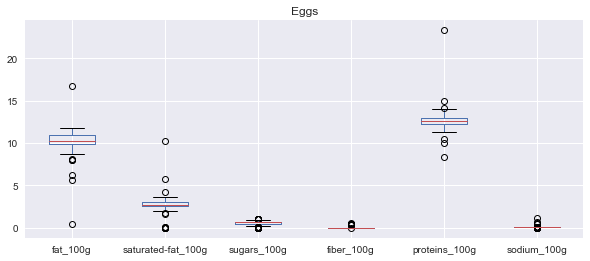

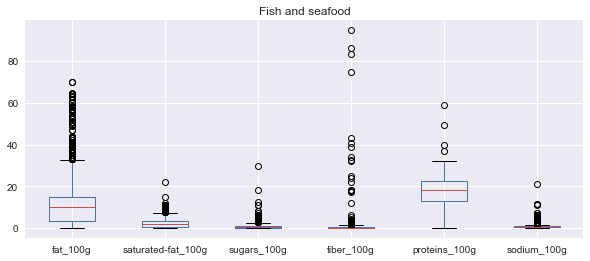

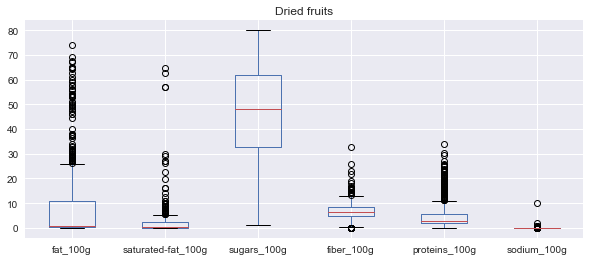

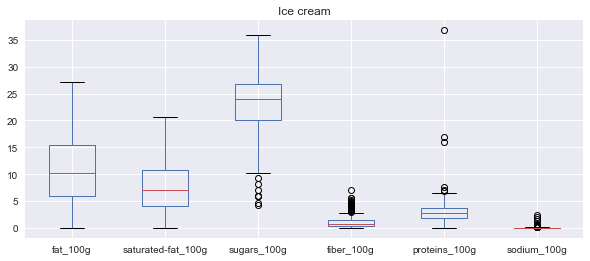

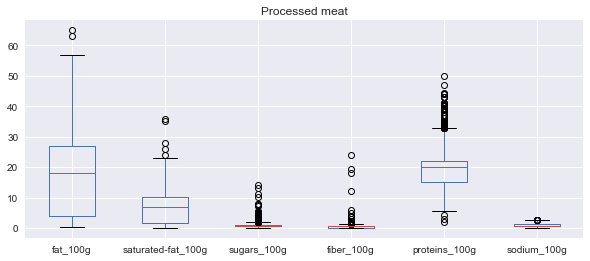

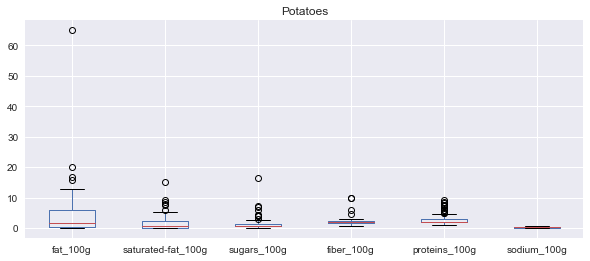

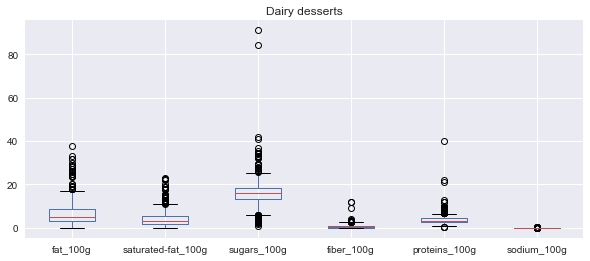

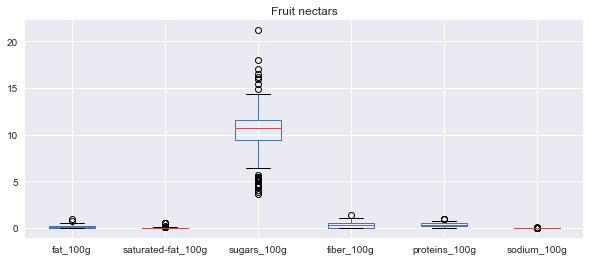

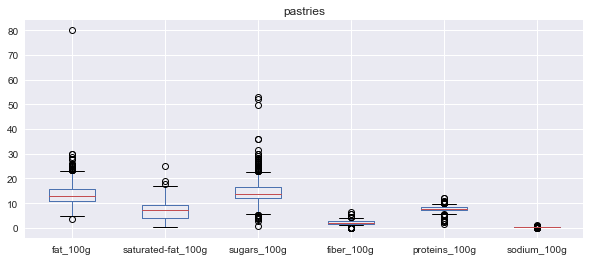

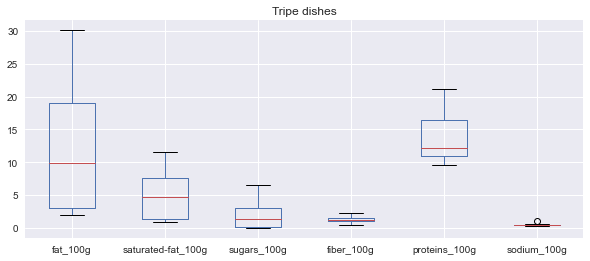

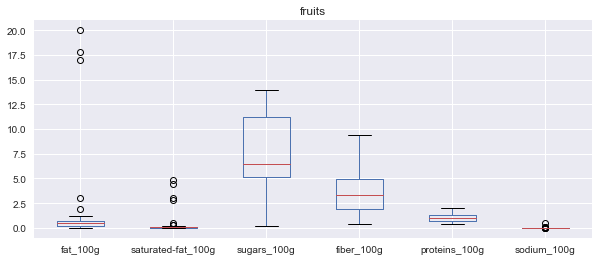

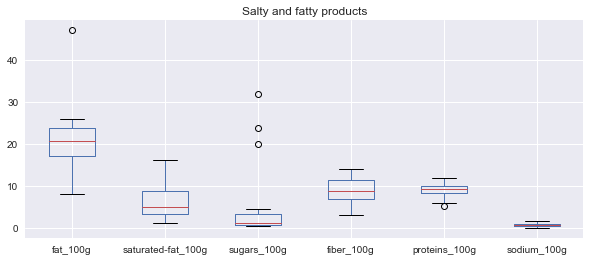

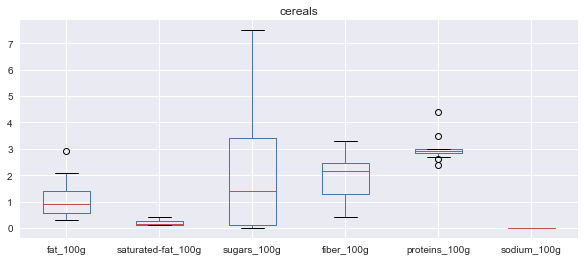

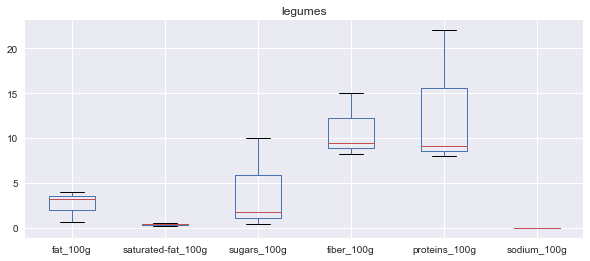

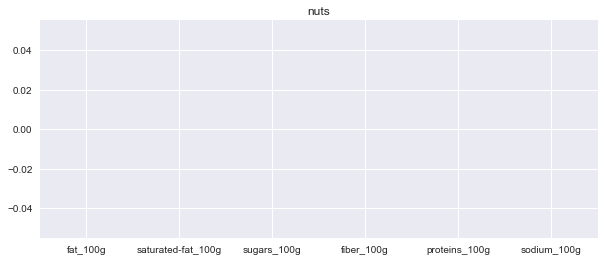

In [40]:
#here for example we visualize the boxplotfor pnss_group2 after deleating outliers 
i=0
group='pnns_groups_2'
list_pnns=list_pnns2
path='Boxplots2_without_outliers/'
for pn in list_pnns:
    i+=1
    plot_box_ingredients_pnss_group(pn,group,df_app,ingredients_g,i,path)

## 3.Imputation<a class="anchor" id="imp"></a>

In [41]:
def fill_nan_code(df,col,init,cp):    
    nb_nan_code=df[col].isna().sum()
    for cp in range(nb_nan_code):
        df[col]=df[col].fillna(str(init+cp)) 

In [42]:
data_without_outliers=df_no_outliers.copy()

In [43]:
#Code variable
max_value = df['code'].astype(float).max() 
fill_nan_code(data_without_outliers,'code',max_value,1)                               


In [44]:
def fill_nan_additives(df,col,value):    
    df[col] = df[col].fillna(value)
    

In [46]:
#Code variable
fill_nan_additives(data_without_outliers,'additives_n',0)   

**Corrélation map(Heatmap)**
<br>
<br>
This card is used in the data cleaning part in order to visualize correlated features with will be imputed using variables  IterativeImputer.

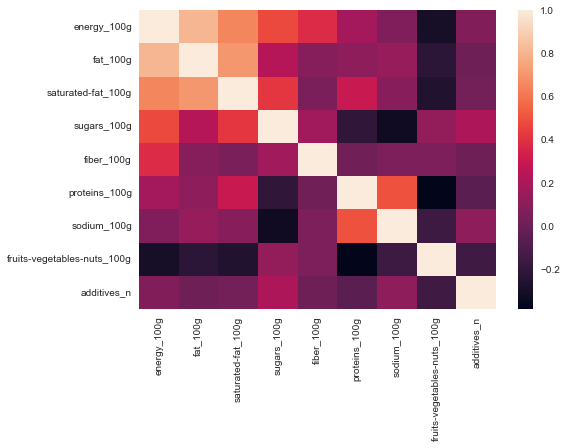

In [47]:
#look for correlated variables
sns.heatmap(data_without_outliers.corr());

In [48]:

def impute_nan(dataframe,cols,method,stategy,n):
    """
    Impute NaN values of specified columns of a dataframe.
    This function simply fill  nan values of correlated columns of a dataframe given the specified method.
    
    Parameters
    ----------
    dataframe : dataframe
        Considerd dataframe.
    cols : list
        Specified feature names.
    method : string
        possible values:'Iterative_Imputer','KNN_Imputer','Simple_Imputer'
    stategy : string
        when method is equal to 'Simple_Imputer', strategy must be defined.
        Its possible values are:'mean','median','most_frequent','constant'
    n : int
        number of neighbors.
    Returns
    -------
    dataframe
        The dataframe with imputed columns 'cols'

    Examples
    --------
    >>> df_output=(dataframe,['c1','c2'],'Iterative_Imputer','')
    >>> df_output=(dataframe,['c1','c2'],'Simple_Imputer','mean')

    """
    df=dataframe[cols]
    cols = [col for col in df.columns if df[col].dtype != object]
    if method=='Iterative_Imputer':
        # create an object for for IterativeImputer
        iter_imputer = IterativeImputer(random_state=42)
        df_imputed = iter_imputer.fit_transform(df[cols])        
        #df_imputed = pd.DataFrame(iter_imputed, columns=cols)
    elif method=='KNN_Imputer':
        # create an object for KNNImputer
        knn_imputer = KNNImputer(n_neighbors=n)
        df_imputed=knn_imputer.fit_transform(df[cols])
    else: 
        simple_imputer=SimpleImputer(missing_values=np.NaN, strategy=strategy)
        df_imputed=simple_imputer.fit_transform(df[cols])
    
    df_output=df_imputed
    return df_output

In [49]:
#before imputation,we make a copy of df_app called df_app_copy 
data_without_outliers_copy=data_without_outliers.copy()


In [50]:
correlated_ingredients=[['fat_100g','energy_100g'],['saturated-fat_100g','energy_100g'],['fat_100g', 'saturated-fat_100g'],
                       ['proteins_100g','sodium_100g']]

In [51]:
#correlated ingredients with Iterative_Imputer

for col in correlated_ingredients:
    df_after_imputation=impute_nan(data_without_outliers,col,'Iterative_Imputer','',0)
    data_without_outliers[col]=df_after_imputation



In [85]:
#correlated ingredients touse for KNN_Imputer
#correlated_ingredients_KNN=[['fat_100g', 'saturated-fat_100g'],['proteins_100g','sodium_100g']]
#for col in correlated_ingredients_KNN:
 #   df_after_imputation=impute_nan(data_without_outliers,col,'KNN_Imputer','',len(list_pnns2))
 #   data_without_outliers[col]=df_after_imputation


KeyboardInterrupt



**Note**<br>
KNNIterative is a memory consumer for my pc

In [52]:
#control min max
print(data_without_outliers[ingredients].apply(minMax_ingredients))

       fat_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
min   -4.587457           -0.687434          0.0         0.0            0.0   
max  100.000000           31.000000         86.0         7.9           37.0   

     sodium_100g  energy_100g  
min     0.000000     0.000000  
max     1.732283  4571.817739  


**Remarque**
<br>
 - Imputation gives <0 values fat_100g and satured_fat_100g

In [53]:
def remove_negatif_ingredient(dataframe,column,limit):
    #df_no_negatif = dataframe[(dataframe[column]>limit)]
    dataframe.drop(dataframe[(dataframe[column] < limit)].index,inplace=True)

In [54]:
#keep only values with postif fat_100g and saturated-fat_100g
remove_negatif_ingredient(data_without_outliers,'fat_100g',0)
remove_negatif_ingredient(data_without_outliers,'saturated-fat_100g',0)

In [55]:
print_shape(data_without_outliers)

Number of rows: 60270 

Number of columns: 12


In [56]:
#control min max
print(data_without_outliers[ingredients].apply(minMax_ingredients))

     fat_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
min       0.0                 0.0          0.0         0.0            0.0   
max     100.0                31.0         86.0         7.9           37.0   

     sodium_100g  energy_100g  
min     0.000000     0.000000  
max     1.732283  4571.817739  


In [58]:
for ing in ingredients_g:
    data_without_outliers.drop(data_without_outliers[(data_without_outliers[ing] < seuil_up_100) | (data_without_outliers[ing] > seuil_low_100)].index,inplace=True)

In [59]:
#'sugars_100g'
# Replace NaNs in column sugars_100g with the
# mean of values in the same column
data_without_outliers['sugars_100g'].fillna(value=data_without_outliers['sugars_100g'].mean(), inplace=True)


In [60]:
# 'fiber_100g'
# Replace NaNs in column fiber_100g with the
# mean of values in the same column
data_without_outliers['fiber_100g'].fillna(value=data_without_outliers['fiber_100g'].mean(), inplace=True)

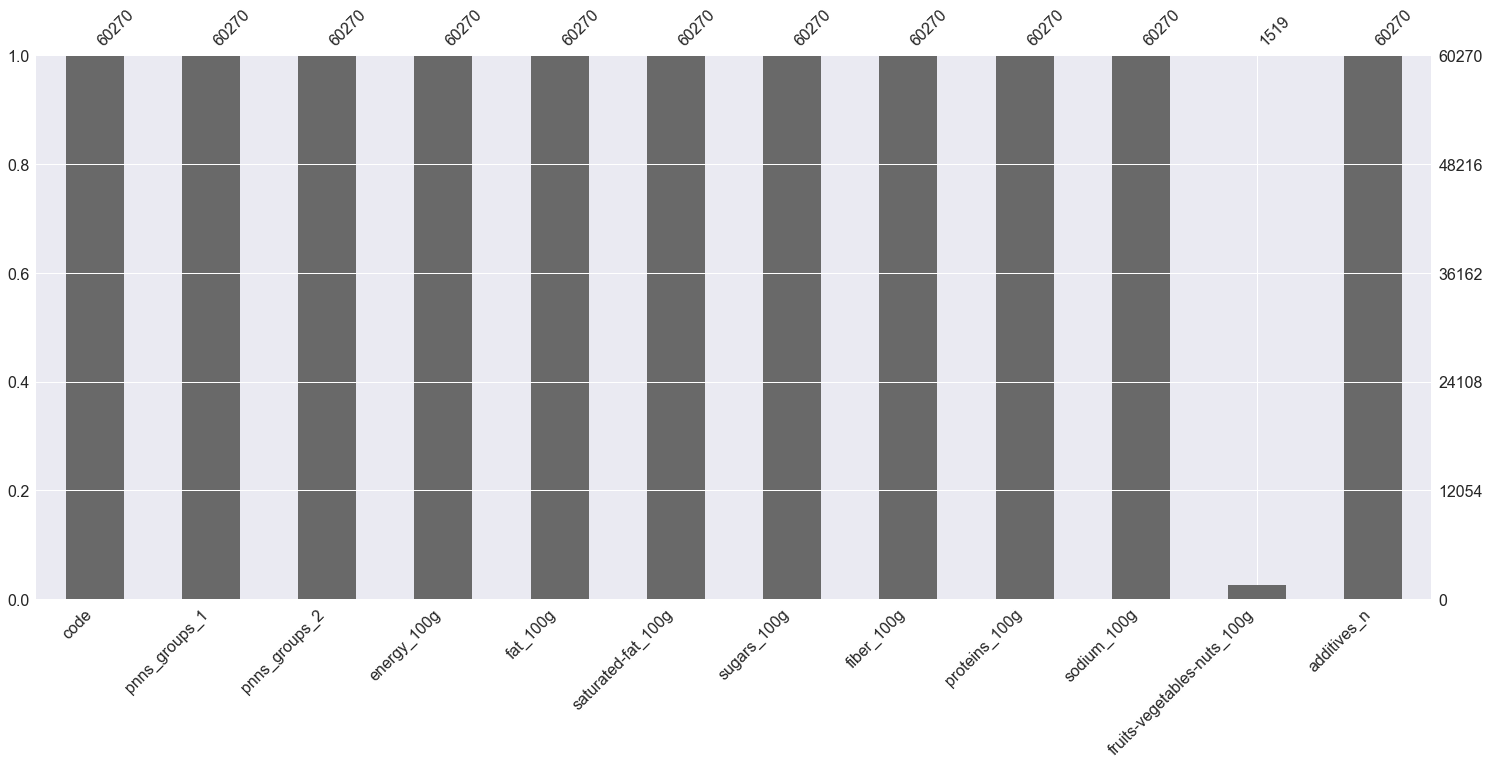

In [61]:
print_missing_val(data_without_outliers,'graph')

**Note**
<br>
 - fruits_vegetables_nuts_100g  contains a lot of nan it will not be considered in the variables application

## 4.Sauvegarde des données dans un fichier csv<a class="anchor" id="cs"></a>


In [62]:
#save the resulting dataframe in .csv file in order to be using in the exploration notebook
file_name='data_exploration.csv'
clean_dataset=data_without_outliers[['code', 'pnns_groups_1', 'pnns_groups_2', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'sodium_100g','additives_n']]
clean_dataset.to_csv(file_name, sep='\t',index=False)